# This code should plot out the most figures I need in section 3.2

In [1]:
import numpy as np
import datetime
import threading
import multiprocessing as mp
from matplotlib import pyplot as plt
from time import time
from scipy.stats import norm
import sympy
%matplotlib inline
plt.style.use('bmh')
import scipy
from scipy import stats
from scipy import sparse
from scipy.sparse import linalg
from scipy.sparse.linalg import spsolve
from scipy.stats import norm

In [2]:
import sympy
z = sympy.symbols('z')
K0 = 1e-6# m * * 2 / s
K1 = 6e-3# m / s
Aalpha = 0.5
c=20
w=0

sym_Diffu =  K0 + K1 * z * sympy.exp(-Aalpha * z)
sym_dKdz = sympy.diff(sym_Diffu, z, 1)
sym_Beta = sympy.sqrt(2 * sym_Diffu)
sym_dBdz = sympy.diff(sym_Beta, z, 1)
sym_ddBdzz = sympy.diff(sym_Beta, z, 2)
sym_Alpha = w + sym_dKdz
sym_dAdz = sympy.diff(sym_Alpha, z, 1)
sym_ddAdzz = sympy.diff(sym_Alpha, z, 2)
sym_dABdz = sympy.diff(sym_Alpha * sym_Beta, z, 1)

Diffu  =  sympy.utilities.lambdify(z,          sym_Diffu,np)
dKdz   =  sympy.utilities.lambdify(z,          sym_dKdz,np)
Beta   =  sympy.utilities.lambdify(z,          sym_Beta,np)
dBdz   =  sympy.utilities.lambdify(z,          sym_dBdz,np)
ddBdzz=  sympy.utilities.lambdify(z,          sym_ddBdzz,np)
Alpha =  sympy.utilities.lambdify(z,      sym_Alpha,np)
dAdz  =  sympy.utilities.lambdify(z,      sym_dAdz,np)
ddAdzz=  sympy.utilities.lambdify(z,      sym_ddAdzz,np)
dABdz =  sympy.utilities.lambdify(z, sym_Alpha*sym_Beta,np)


In [3]:
#######
#Euler#
#######
def step_e(z, H, dt, N_sample):

    dW = np.random.normal(0, np.sqrt(dt), N_sample)
    a = dKdz(z)
    b = np.sqrt(2 * Diffu(z))
    temp = z + a * dt + b * dW
    return temp


def step_e_const(z, H, dt, N_sample):

    dW = np.random.normal(0, np.sqrt(dt), N_sample)
    K0 = 3e-3
    b = np.sqrt(2 * K0)

    temp = z + b * dW
    return temp


########
#Visser#
########
def step_v(z, H, dt, N_sample):

    #Original
    #dW=np.random.uniform(-1,1,N_sample)
    #r=1/3

    #Wiener process
    dW = np.random.normal(0, np.sqrt(dt), N_sample)
    r = dt

    a = dKdz(z)
    G = Diffu(z + a * dt / 2)

    temp = z + a * dt + np.sqrt(2 / r * dt * G) * dW
    return temp


def step_v_const(z, H, dt, N_sample):
    K0 = 3e-3

    #Original
    #dW=np.random.uniform(-1,1,N_sample)
    #r=1/3

    #Wiener process
    dW = np.random.normal(0, np.sqrt(dt), N_sample)
    r = dt

    temp = z + np.sqrt(2 / r * dt * K0) * dW
    return temp


##############
#Milstein 1nd#
##############
def step_m(z, H, dt, N_sample):

    dW = np.random.normal(0, np.sqrt(dt), N_sample)
    temp = z + (1 / 2) * dKdz(z) * (dW * dW + dt) + Beta(z) * dW
    return temp


##############
#Milstein 2nd#
##############
def step_m2(z, H, dt, N_sample):
    dW = np.random.normal(0, np.sqrt(dt), N_sample)

    k = Diffu(z)
    dkdz = dKdz(z)
    ddkdz = dAdz(z)
    dddkdz = ddAdzz(z)
    sqrt2k = np.sqrt(2 * k)

    a = dkdz
    da = ddkdz
    dda = dddkdz
    b = sqrt2k
    db = dkdz / b
    ddb = ddkdz / b - ((dkdz)**2) / b**3
    ab = da * b + a * db

    temp= z + a*dt+b*dW+1/2*b*db*(dW*dW-dt)+1/2*(ab+1/2*ddb*b**2)*dW*dt+\
            1/2*(a*da+1/2*dda*b**2)*dt**2

    return temp


def step_m2_const(z, H, dt, N_sample):
    K0 = 3e-3
    dW = np.random.normal(0, np.sqrt(dt), N_sample)
    temp = z + np.sqrt(2 * K0) * dW
    return temp

In [4]:
def oneStep(Z, scheme, H, dt):

    Z = scheme(Z, H, dt, Z.size)

    Z = np.where(Z < 0, -Z, Z)
    Z = np.where(Z > H, 2 * H - Z, Z)

    return Z

def parallel(Tmax, dt, H, Testdepth, Np, Nbins, quene, scheme):

    np.random.seed()
    Ntime = int(Tmax / dt)

    hist_ = np.zeros((Nbins - 1, ), 'i')

    z = np.random.uniform(0, H, int(Np))

    for i in range(Ntime):

        z = oneStep(z, scheme, H, dt)

        #Adding the histogram
        ###
        temp0, _ = np.histogram(z, bins=np.linspace(0, Testdepth, Nbins))
        hist_ = hist_ + temp0

        if (i % int(Ntime / 100) == 0):
            print("\r %6.2f" % (i * 100 / Ntime + 1),
                  "%",
                  end="\r",
                  flush=True)

    quene.put(hist_)

    return None

def RunSimulation(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins, scheme):
    print("Total number of process: ", NumberOfThread)
    SubNp = np.full((NumberOfThread, ), int(Np / NumberOfThread))
    SubNp[-1] = SubNp[-1] + (Np % NumberOfThread)

    Ntime = int(Tmax / dt)  #Number of time interval
    counter = Ntime

    if (__name__ == '__main__'):

        threads = []
        quene = mp.Queue()

        for i in range(NumberOfThread):
            thread = mp.Process(target=parallel,
                                args=(Tmax, dt, H, Testdepth, SubNp[i], Nbins,
                                      quene, scheme))

            threads.append(thread)
            thread.start()  #starting calculation.

        for thread in threads:
            thread.join()  #waiting these processes finish.

    hist_ = np.zeros((Nbins - 1, ), 'i')

    for i in range(NumberOfThread):
        hist_ += quene.get()

    bins = np.linspace(0, Testdepth, Nbins)
    dz = bins[1] - bins[0]
    hist_ = (hist_ * H) / (Np * dz * (Ntime + 1))

    return hist_

## Figure 3.2

In [5]:
Np = 240000
Nbins = 2000
dt = 10
Tmax = dt * 1 * 3600
H = 10
Testdepth = 10
NumberOfThread = 4

startTime = time()
E1_whole= RunSimulation(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins, step_e)

E1_C_whole = RunSimulation(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins,
                     step_e_const)

V1_whole = RunSimulation(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins, step_v)

V1_C_whole = RunSimulation(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins,
                     step_v_const)

M1_whole = RunSimulation(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins, step_m)

M2_whole = RunSimulation(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins, step_m2)

endTime = time()
print("Time elapsed: ", endTime - startTime)

Total number of process:  4
Total number of process:  4
Total number of process:  4
Total number of process:  4
Total number of process:  4
Total number of process:  4
Time elapsed:  336.3502206802368


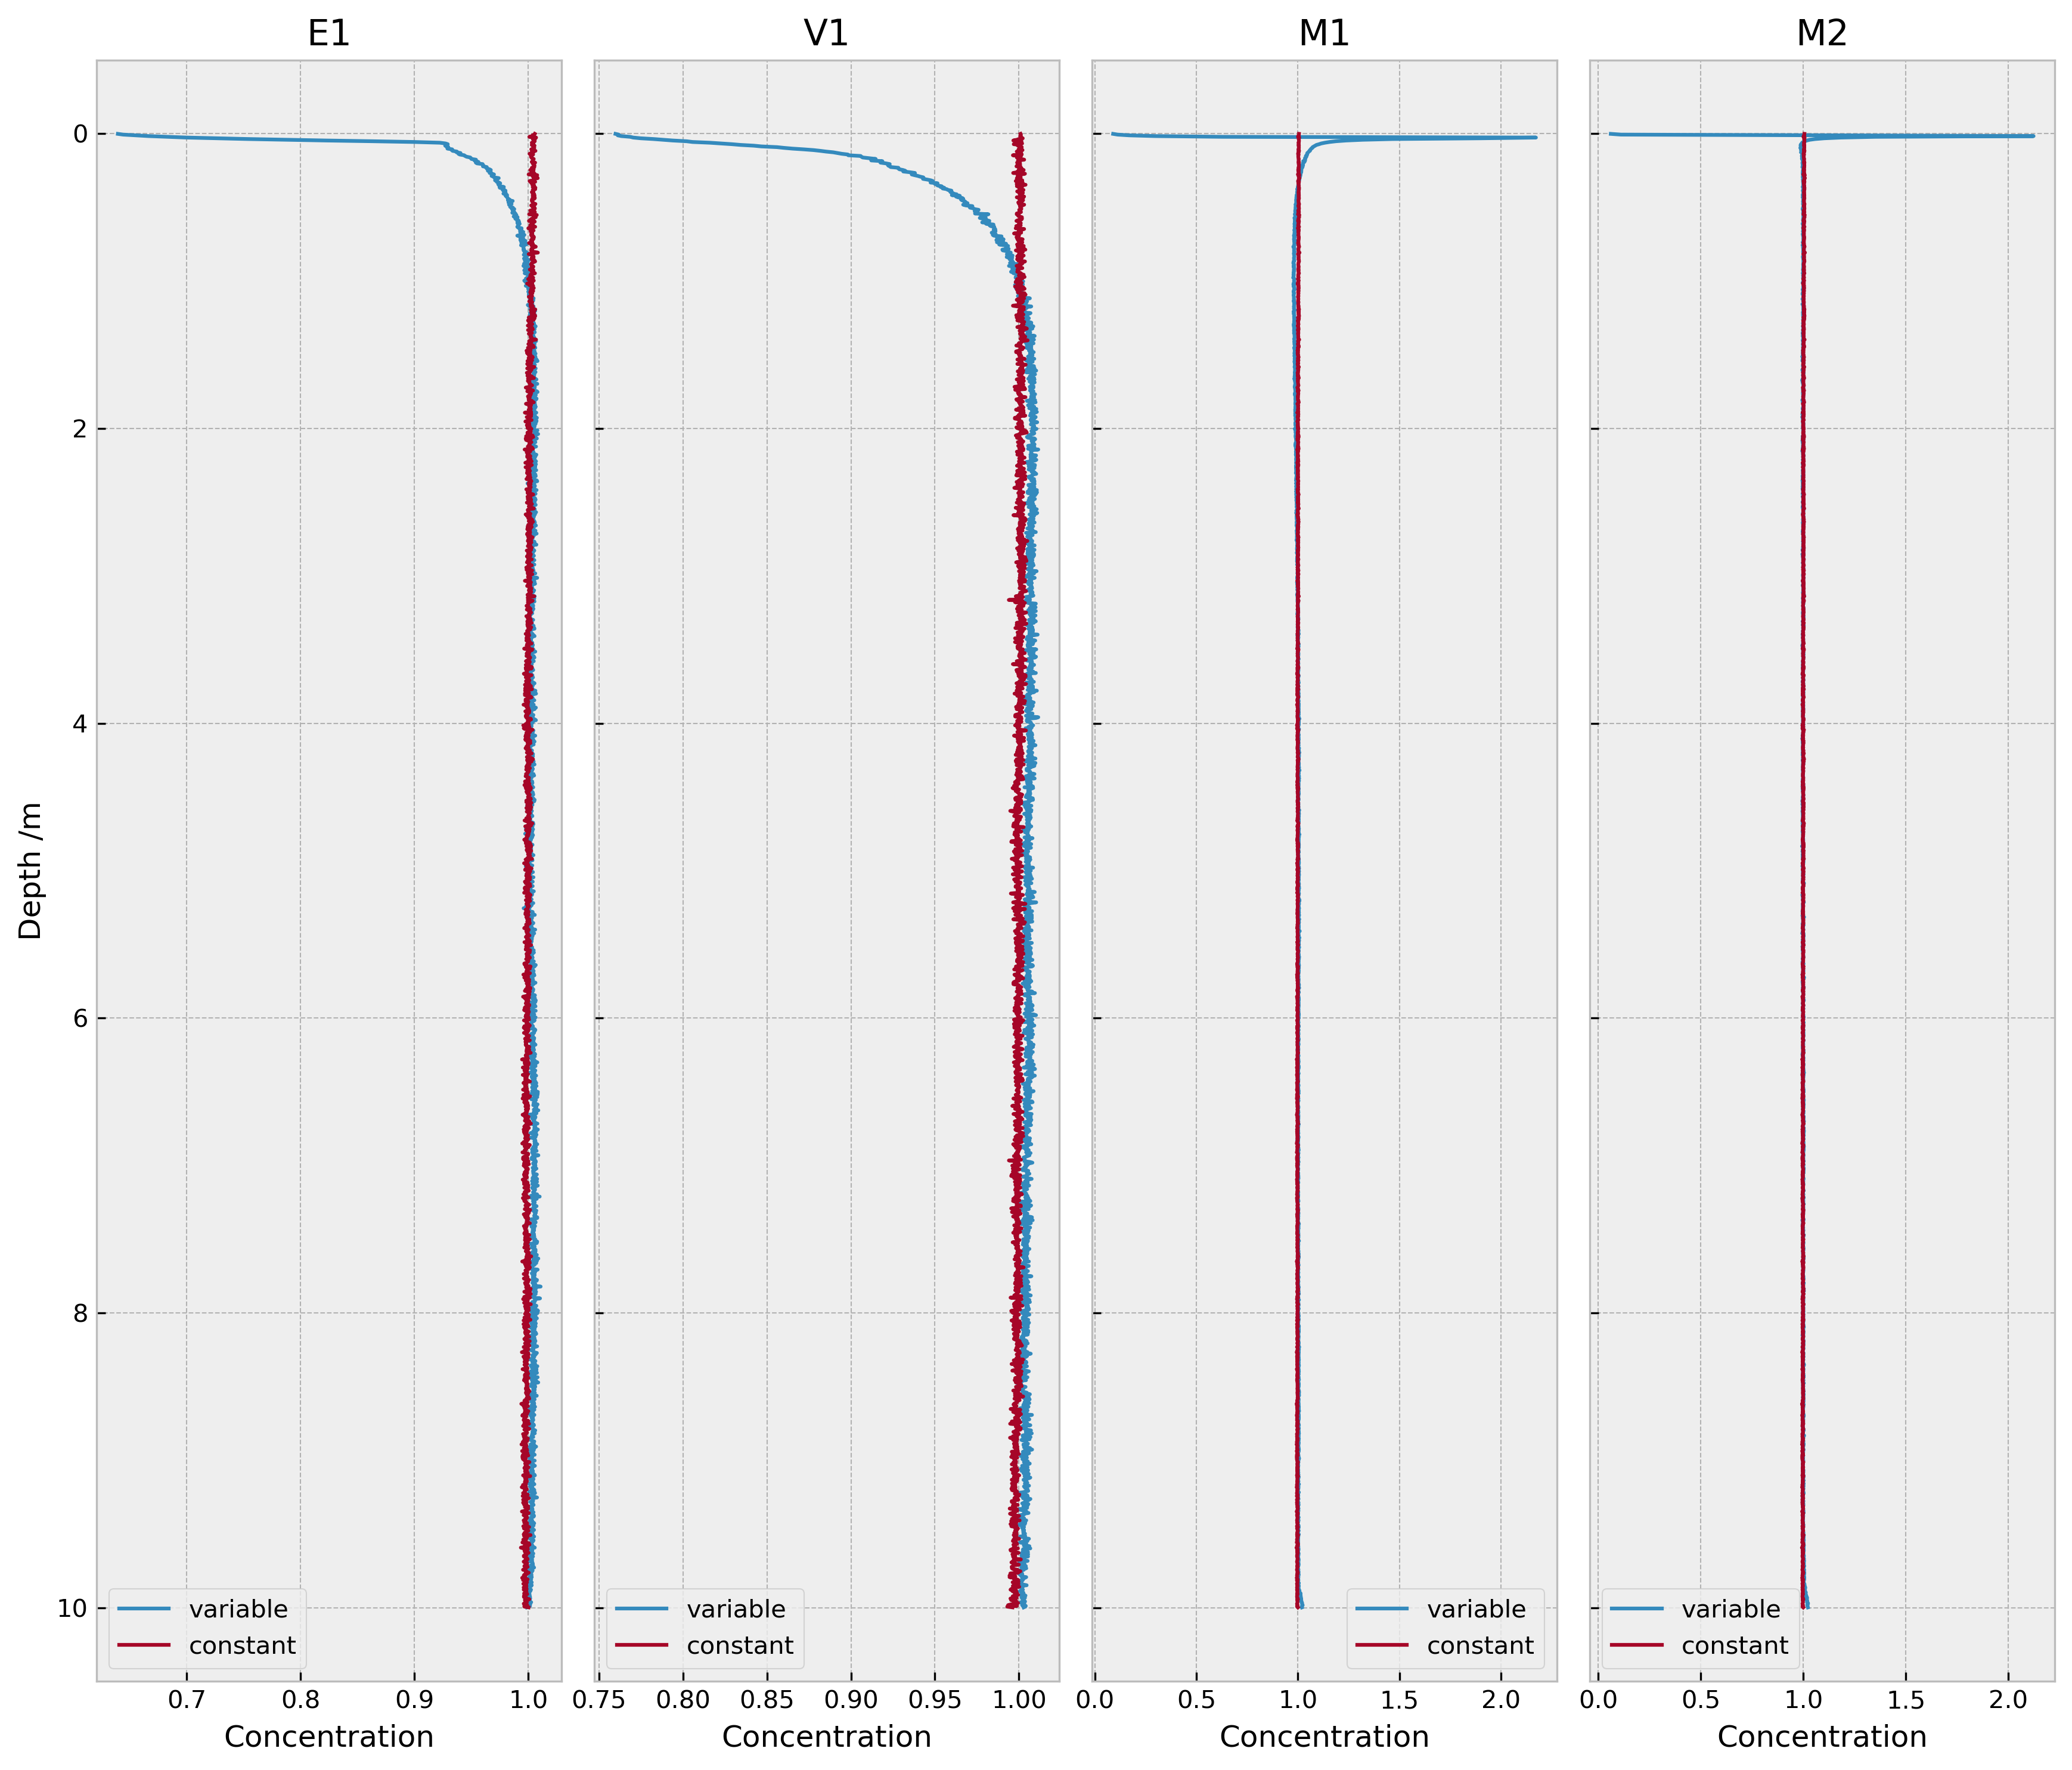

In [6]:
#
bins = np.linspace(0, Testdepth, Nbins)
midpoints = bins[:-1] + (bins[1]-bins[0]) / 2

fig, ax = plt.subplots(ncols = 4, figsize = (11.69,10), sharey = True, dpi = 300)
ax[0].plot(E1_whole, midpoints, linewidth=1.5, label= "variable")
ax[0].plot(E1_C_whole, midpoints, linewidth=1.5, label= "constant")
ax[0].set_xlabel('Concentration')
ax[0].set_ylabel('Depth /m')
ax[0].set_title('E1')
ax[0].invert_yaxis()
ax[0].legend()

ax[1].plot(V1_whole, midpoints, linewidth=1.5, label= "variable")
ax[1].plot(V1_C_whole, midpoints, linewidth=1.5, label= "constant")
ax[1].set_xlabel('Concentration')
ax[1].set_title('V1')
ax[1].legend()

ax[2].plot(M1_whole, midpoints, linewidth=1.5, label= "variable")
ax[2].plot(E1_C_whole, midpoints, linewidth=1.5, label= "constant")
ax[2].set_xlabel('Concentration')
ax[2].set_title('M1')
ax[2].legend()

ax[3].plot(M2_whole, midpoints, linewidth=1.5, label= "variable")
ax[3].plot(E1_C_whole, midpoints, linewidth=1.5, label= "constant")
ax[3].set_xlabel('Concentration')
ax[3].set_title('M2')
ax[3].legend()

plt.tight_layout()

## Figure 3.3

In [7]:
Np = 240000
Nbins = 200
dt = 10
Tmax = dt * 1 * 3600
H = 10
Testdepth = 0.2
NumberOfThread = 4

startTime = time()
E1 = RunSimulation(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins, step_e)

E1_C = RunSimulation(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins,
                     step_e_const)

V1 = RunSimulation(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins, step_v)

V1_C = RunSimulation(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins,
                     step_v_const)

M1 = RunSimulation(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins, step_m)

M2 = RunSimulation(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins, step_m2)

endTime = time()
print("Time elapsed: ", endTime - startTime)

Total number of process:  4
Total number of process:  4
Total number of process:  4
Total number of process:  4
Total number of process:  4
Total number of process:  4
Time elapsed:  334.84914660453796


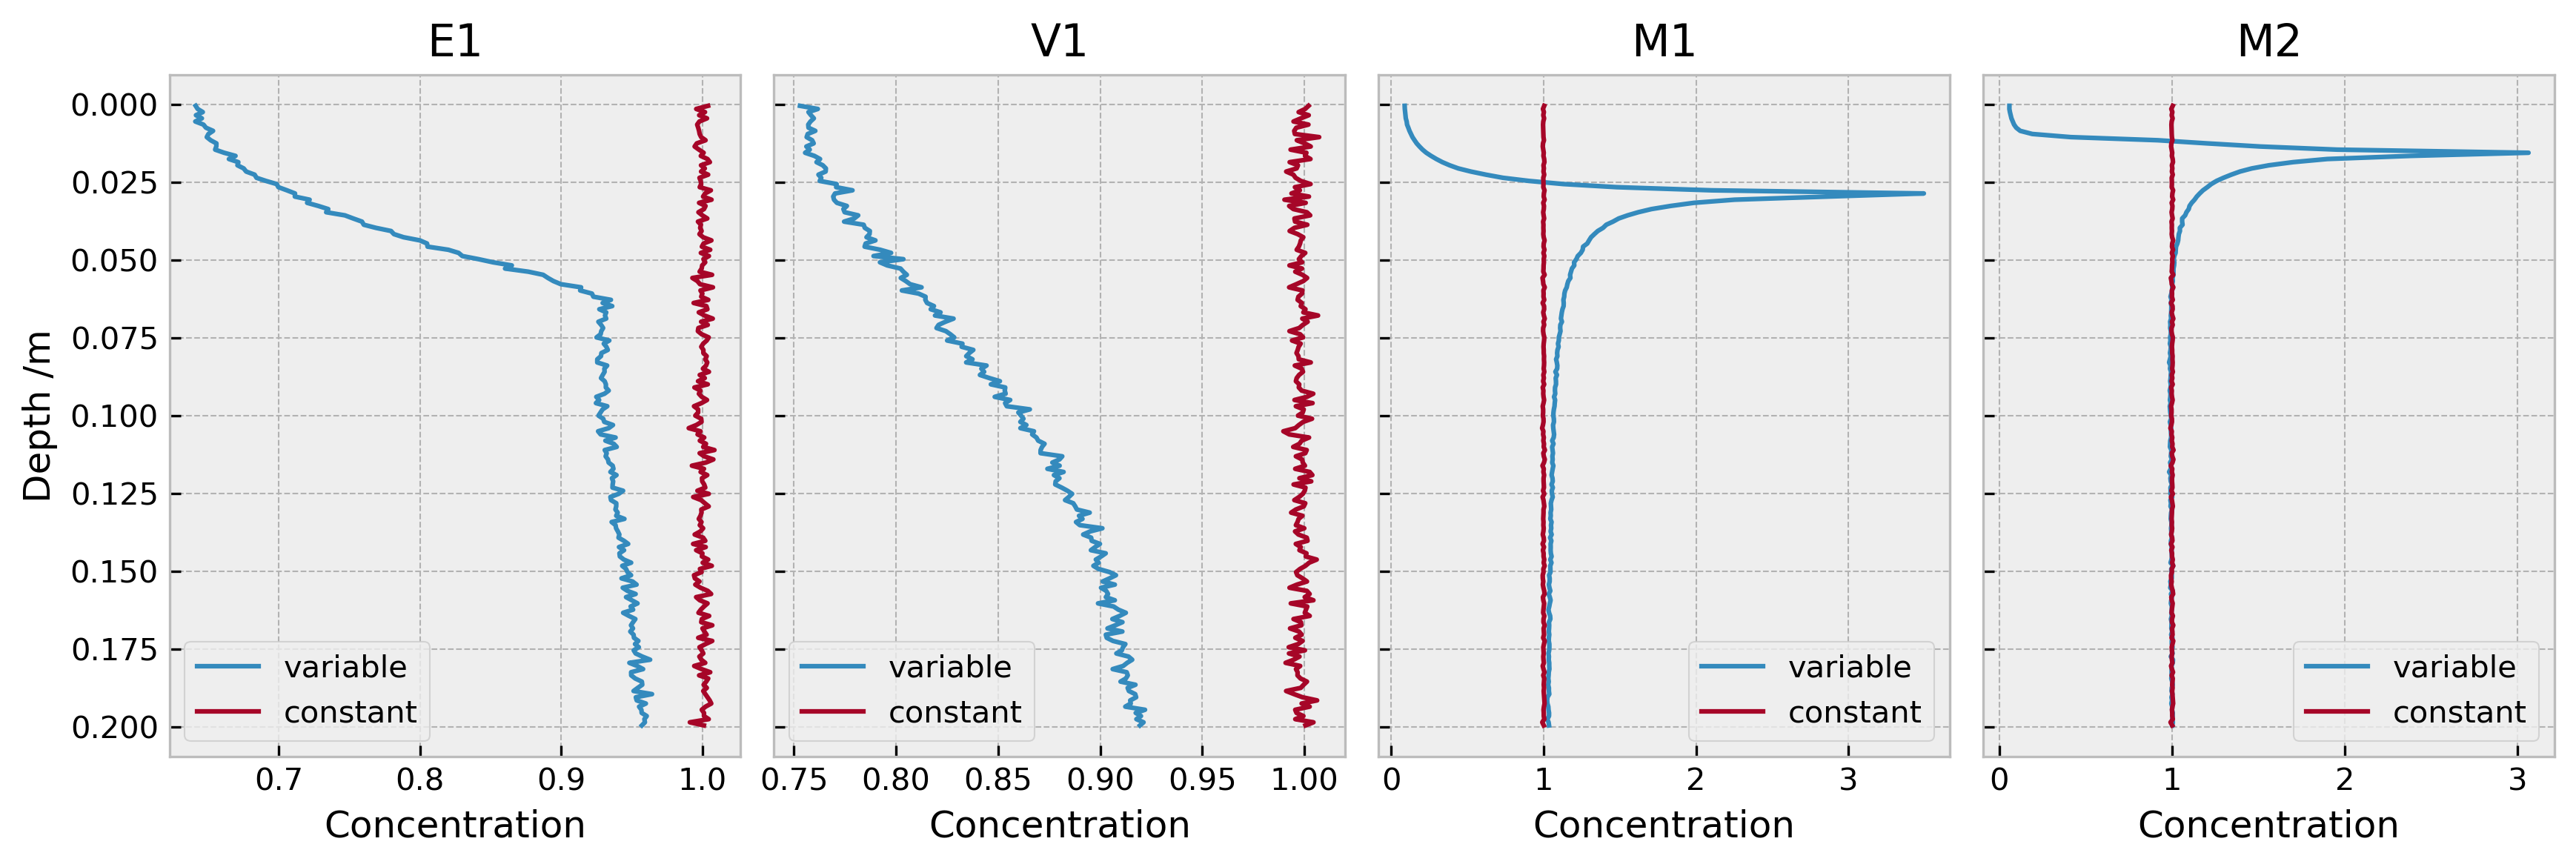

In [8]:
#
bins = np.linspace(0, Testdepth, Nbins)
midpoints = bins[:-1] + (bins[1]-bins[0]) / 2

fig, ax = plt.subplots(ncols = 4, figsize = (11.69,4), sharey = True, dpi = 300)
ax[0].plot(E1, midpoints, linewidth=1.5, label= "variable")
ax[0].plot(E1_C, midpoints, linewidth=1.5, label= "constant")
ax[0].set_xlabel('Concentration')
ax[0].set_ylabel('Depth /m')
ax[0].set_title('E1')
ax[0].invert_yaxis()
ax[0].legend()

ax[1].plot(V1, midpoints, linewidth=1.5, label= "variable")
ax[1].plot(V1_C, midpoints, linewidth=1.5, label= "constant")
ax[1].set_xlabel('Concentration')
ax[1].set_title('V1')
ax[1].legend()

ax[2].plot(M1, midpoints, linewidth=1.5, label= "variable")
ax[2].plot(E1_C, midpoints, linewidth=1.5, label= "constant")
ax[2].set_xlabel('Concentration')
ax[2].set_title('M1')
ax[2].legend()

ax[3].plot(M2, midpoints, linewidth=1.5, label= "variable")
ax[3].plot(E1_C, midpoints, linewidth=1.5, label= "constant")
ax[3].set_xlabel('Concentration')
ax[3].set_title('M2')
ax[3].legend()

plt.tight_layout()

## Figure 3.4 

Here we simulate $\Delta t$ = 0.1

In [9]:
Np = 240000
Nbins = 200
dt = 0.1
Tmax = dt * 10 * 3600
H = 10
Testdepth = 0.01
NumberOfThread = 4

startTime = time()
E1_3 = RunSimulation(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins,
                      step_e)

E1_C_3 = RunSimulation(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins,
                        step_e_const)

V1_3 = RunSimulation(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins,
                      step_v)

V1_C_3 = RunSimulation(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins,
                        step_v_const)

M1_3 = RunSimulation(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins,
                      step_m)

M2_3 = RunSimulation(NumberOfThread, Tmax, dt, H, Testdepth, Np, Nbins,
                      step_m2)

endTime = time()
print("Time elapsed: ", endTime - startTime)

Total number of process:  4
Total number of process:  4
Total number of process:  4
Total number of process:  4
Total number of process:  4
Total number of process:  4
Time elapsed:  3147.720624923706


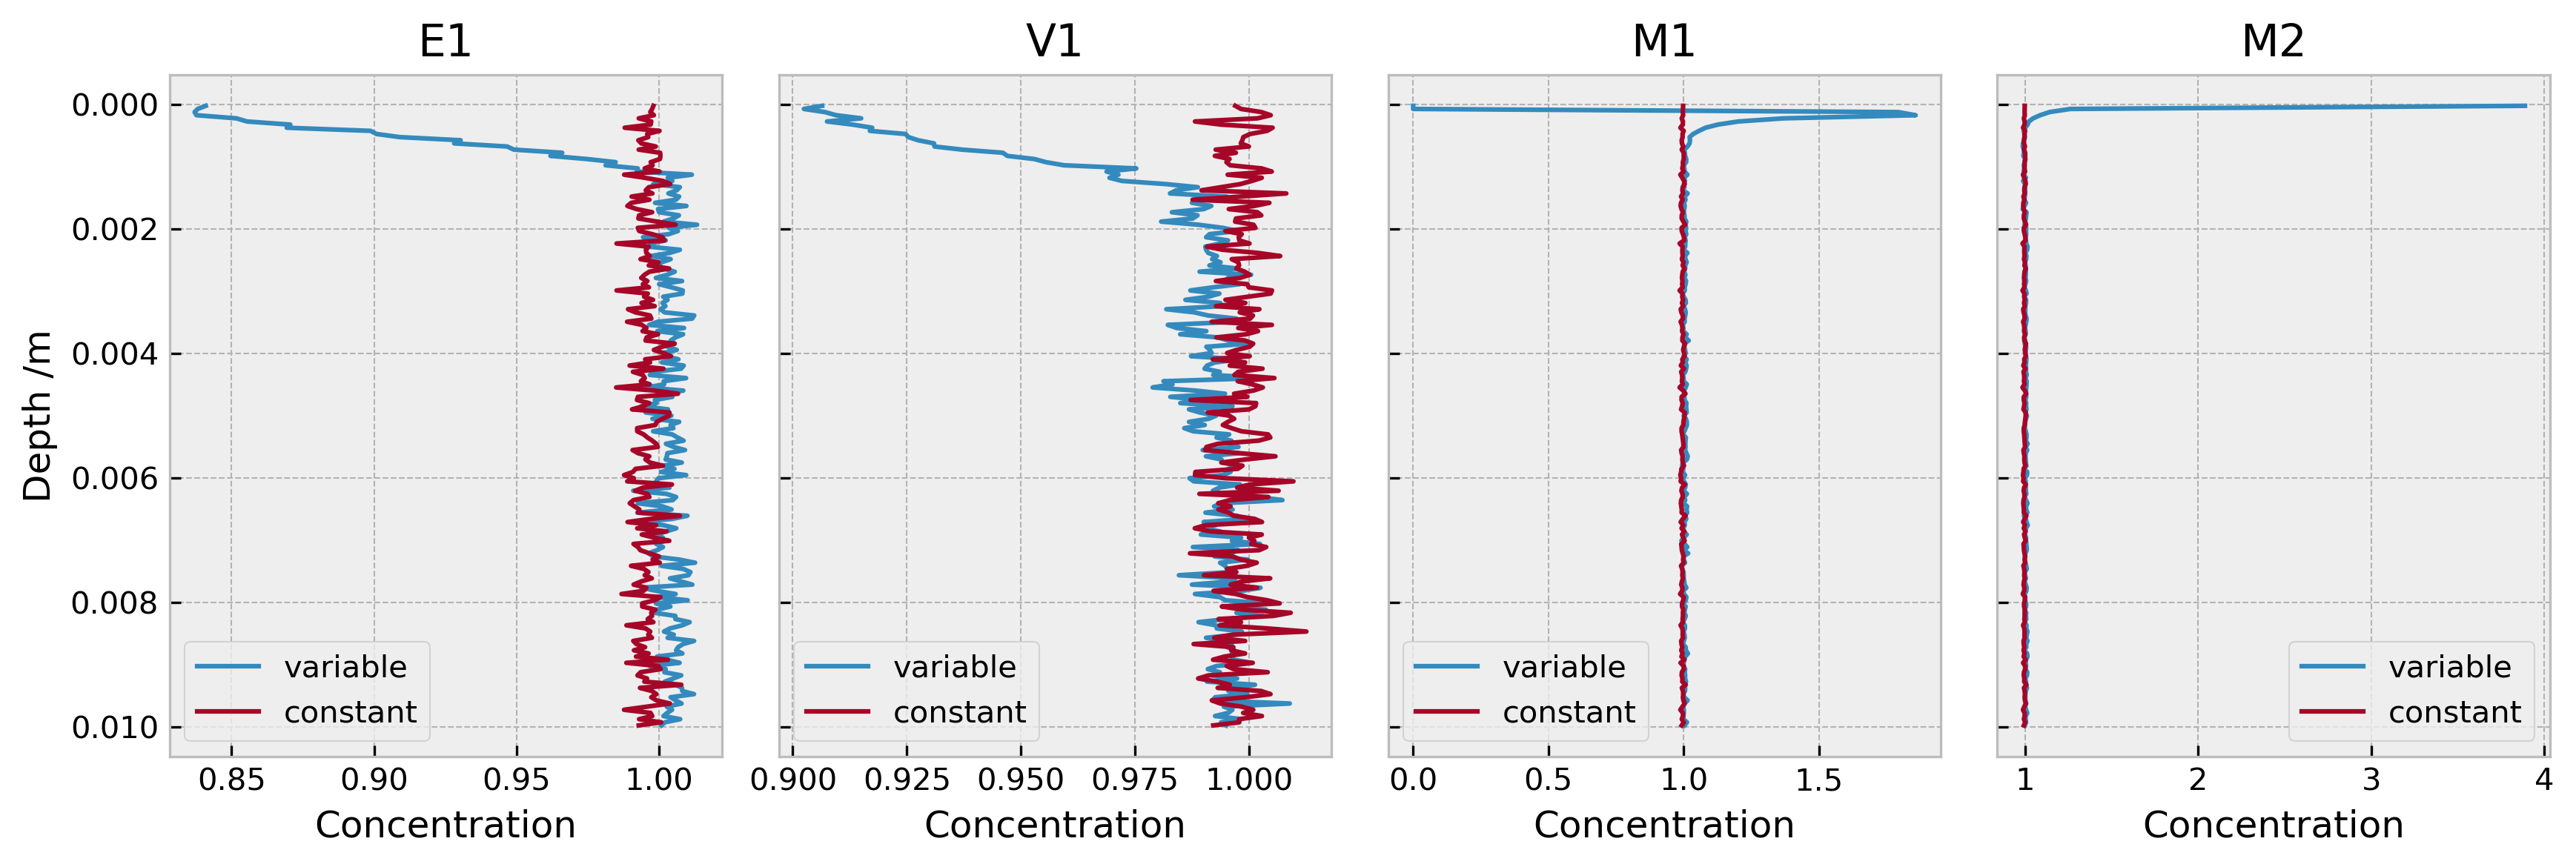

In [10]:
bins = np.linspace(0, Testdepth, Nbins)
midpoints = bins[:-1] + (bins[1]-bins[0]) / 2

fig, ax = plt.subplots(ncols = 4, figsize = (11.69,4), sharey = True, dpi = 300)
#fig, ax = plt.subplots(ncols = 4, figsize = (11.69,8.27))
ax[0].plot(E1_3, midpoints, linewidth=1.5, label= "variable")
ax[0].plot(E1_C_3, midpoints, linewidth=1.5, label= "constant")
ax[0].set_xlabel('Concentration')
ax[0].set_ylabel('Depth /m')
ax[0].set_title('E1')
ax[0].invert_yaxis()
ax[0].legend()

ax[1].plot(V1_3, midpoints, linewidth=1.5, label= "variable")
ax[1].plot(V1_C_3, midpoints, linewidth=1.5, label= "constant")
ax[1].set_xlabel('Concentration')
ax[1].set_title('V1')
ax[1].legend()

ax[2].plot(M1_3, midpoints, linewidth=1.5, label= "variable")
ax[2].plot(E1_C_3, midpoints, linewidth=1.5, label= "constant")
ax[2].set_xlabel('Concentration')
ax[2].set_title('M1')
ax[2].legend()

ax[3].plot(M2_3, midpoints, linewidth=1.5, label= "variable")
ax[3].plot(E1_C_3, midpoints, linewidth=1.5, label= "constant")
ax[3].set_xlabel('Concentration')
ax[3].set_title('M2')
ax[3].legend()

plt.tight_layout()

# Plot diffusivty profile

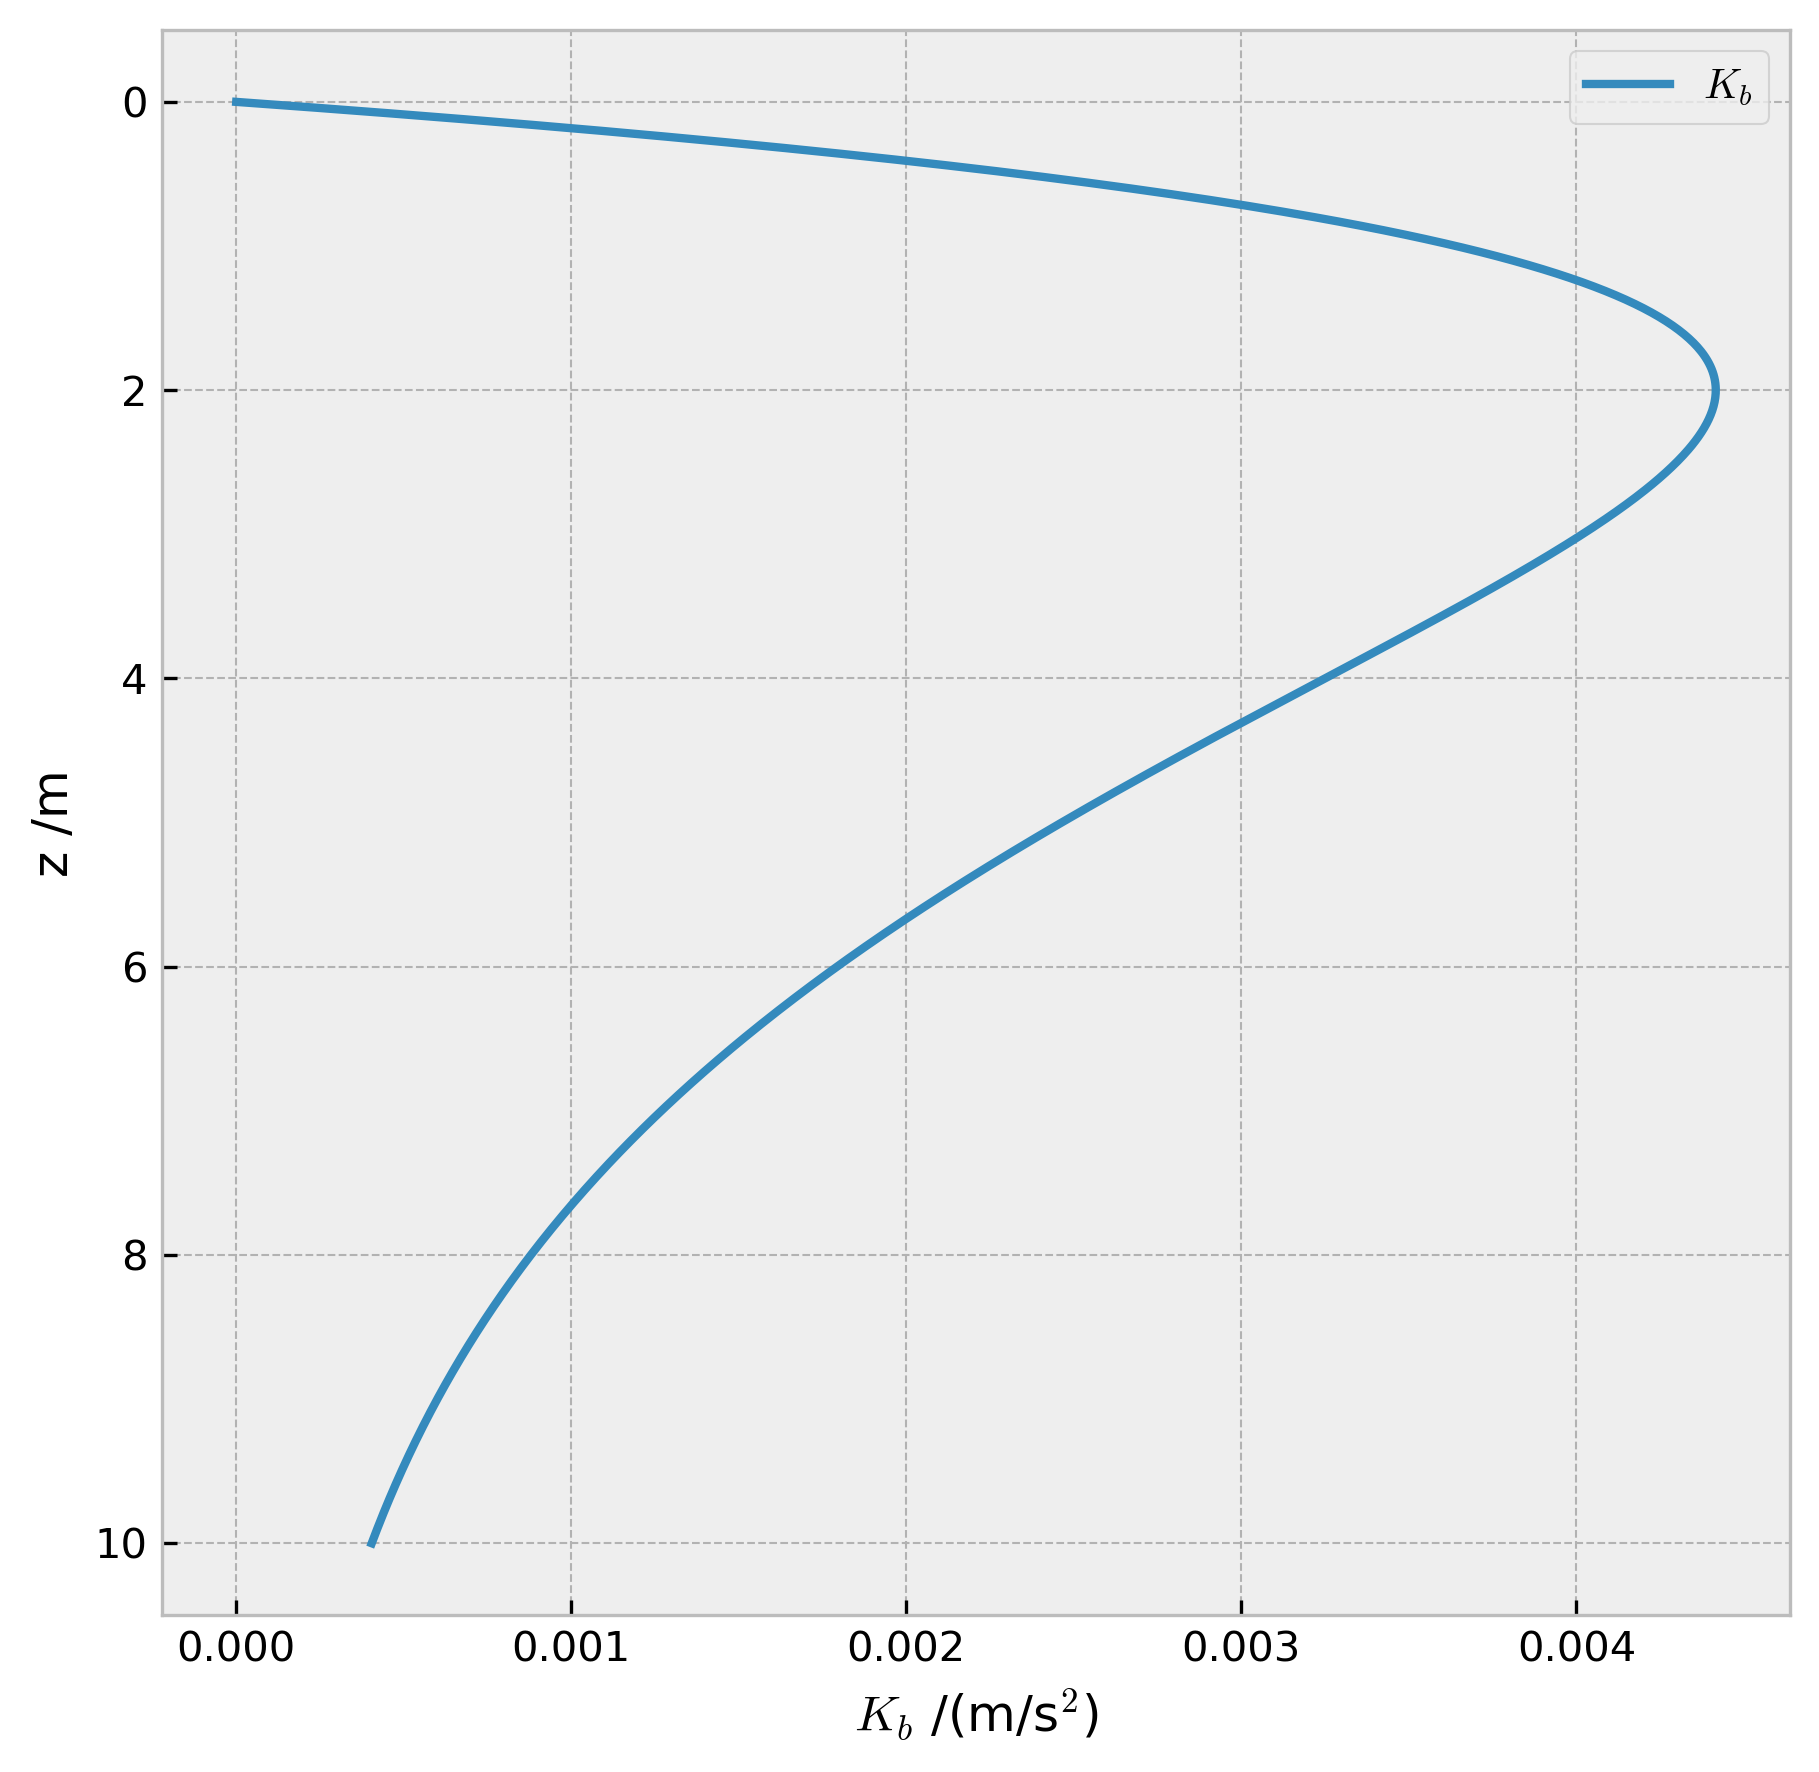

In [11]:
z = np.linspace(0, 10, 1000)
plt.figure(figsize=(7,7), dpi = 300)
plt.plot(Diffu(z), z, label = "$K_b$")
plt.gca().invert_yaxis()
plt.ylabel("z /m")
plt.xlabel("$K_b$ /(m/s$^2$)")
plt.legend()
plt.show()

In [21]:
import os
duration = 1  # seconds
freq = 1440  # Hz
os.system('play -nq -t alsa synth {} sine {}'.format(duration, freq))

0